In [24]:
import pandas as pd 
import numpy as np
import stackprinter 
import matplotlib.pyplot as plt
import random 
from paper_dataprepare import data_preparation 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
stackprinter.set_excepthook(style='darkbg2')

In [2]:
data = pd.read_excel('/Users/tommy84729/python/論文/data/EI.xlsx',encoding = 'utfx-8').drop('利息保障倍數', axis = 'columns')

In [3]:
macro = pd.read_csv('/Users/tommy84729/python/論文/data/macro.csv',encoding = 'big5', index_col = None).drop('年', axis = 'columns')

In [30]:
name1 = ['存貨週轉率（次）', '當季季底P/B']
name2 = ['存貨週轉率（次）', '應收帳款週轉次數', '總資產週轉次數', '固定資產週轉次數', '總負債/總淨值','當季季底P/B','淨值']
num = 0.00001
model = data_preparation(data, macro)

In [31]:
model.macro_pre()
model.distress_pre()
model.create_data()
model.creat_X_Y()
model.creat_train_test(0.3)
model.x_train, model.y_train = model.clean_data(name1, name2, num, model.x_train, model.y_train)

In [54]:
class hybrid : 
    
    def __init__(self, x_train, y_train, x_test, y_test, cv, score) :
        
        self.x_train = x_train
        self.y_train = np.array(y_train).ravel()
        self.x_test = x_test
        self.y_test = np.array(y_test).ravel()
        self.score = score
        self.cv = cv
        
    def scale(self) : 
        
        scale = StandardScaler()
        #scale.fit(train)
        self.x_train = scale.fit_transform(self.x_train)
        self.x_test = scale.transform(self.x_test)
        
    def pca(self, n) : 
        self.pca = PCA(n_components = n)
        self.x_train_pca = self.pca.fit_transform(self.x_train)
        self.x_test_pca = self.pca.transform(self.x_test)
        
        
    def logistic(self, param_grid ) : 
        
        self.logistic = GridSearchCV(LogisticRegression(), param_grid , scoring = self.score, cv = self.cv)
        self.logistic.fit(self.x_train, self.y_train)
        print('Logistic training complete ', self.logistic.best_estimator_, self.logistic.best_score_ ,sep = '\n')
        print('===============================')
        
    def svm(self, param_grid) :
        
        self.svm = GridSearchCV(SVC(), param_grid , scoring = self.score, cv = self.cv)
        self.svm.fit(self.x_train, self.y_train)
        print('SVM training complete', self.svm.best_estimator_, self.svm.best_score_ ,sep = '\n')
        print('===============================')
    
    def rf(self, param_grid) :
        
        self.rf = GridSearchCV(RandomForestClassifier(), param_grid , scoring = self.score, cv = self.cv)
        self.rf.fit(self.x_train, self.y_train)
        print('RF training complete', self.rf.best_estimator_, self.rf.best_score_ ,sep = '\n')
        print('===============================')
        
    def mlp(self, param_grid) :
        
        self.mlp = GridSearchCV(MLPClassifier(), param_grid , scoring = self.score, cv = self.cv)
        self.mlp.fit(self.x_train, self.y_train)
        print('MLP training complete', self.mlp.best_estimator_,self.mlp.best_score_ , sep = '\n')
        print('===============================')
        
        
    def meta_data(self) : 
        
        logit_train = pd.DataFrame(self.logistic.predict_proba(self.x_train)[:,0])
        logit_test = pd.DataFrame(self.logistic.predict_proba(self.x_test)[:,0])
        svm_train = pd.DataFrame(self.svm.predict_proba(self.x_train)[:,0])
        svm_test = pd.DataFrame(self.svm.predict_proba(self.x_test)[:,0])
        rf_train = pd.DataFrame(self.rf.predict_proba(self.x_train)[:,0])
        rf_test = pd.DataFrame(self.rf.predict_proba(self.x_test)[:,0])
        mlp_train = pd.DataFrame(self.mlp.predict_proba(self.x_train)[:,0])
        mlp_test = pd.DataFrame(self.mlp.predict_proba(self.x_test)[:,0])
        self.meta_train = pd.concat([pd.DataFrame(self.x_train_pca), logit_train, svm_train, rf_train, mlp_train], 
                                    axis = 1, 
                                    ignore_index = True)
        self.meta_test = pd.concat([pd.DataFrame(self.x_test_pca), logit_test, svm_test, rf_test, mlp_test], 
                                   axis = 1, 
                                   ignore_index = True)
     
    def hybrid_model(self, param_grid_h_rf, param_grid_h_mlp, cv, score) : 
        
        self.hybrid_rf = GridSearchCV(RandomForestClassifier(), 
                                      param_grid_h_rf , 
                                      scoring = score, 
                                      cv = cv)
        self.hybrid_rf.fit(self.meta_train, self.y_train)
        print('hybrid RF training complete', self.hybrid_rf.best_estimator_,self.hybrid_rf.best_score_ , sep = '\n')
        print('===============================')
        self.hybrid_mlp = GridSearchCV(MLPClassifier(), param_grid_h_mlp , scoring = score, cv = cv)
        self.hybrid_mlp.fit(self.meta_train, self.y_train)
        print('hybrid MLP training complete', self.hybrid_mlp.best_estimator_,self.hybrid_mlp.best_score_ , sep = '\n')
        print('===============================')
    
    def roc_curve(self, model, label, color, linestyle, x, y) : 
        
        for clf, label, clr, ls in zip(model, label, color, linestyle) : 
            y_pred = clf.predict_proba(x)[:, 1]
            fpr, tpr, threshold = roc_curve(y_true = y, 
                                            y_score = y_pred)
            roc_auc = auc(x = fpr, y = tpr)
            plt.plot(fpr, tpr, color = clr, 
                     linestyle = ls, 
                     label = '%s (auc = %0.2f)' %(label, roc_auc))
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1], 
                 color='navy', 
                 lw =2, 
                 linestyle='--')
        plt.xlim([-0.05, 1.0])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        

    @staticmethod    
    def metric(data,true_value, model) : 
        
        cnf =  confusion_matrix(true_value, 
                                model.predict( data))
        acc =  accuracy_score(true_value, model.predict( data))
        prec = precision_score(true_value, model.predict( data))
        recall = recall_score(true_value, model.predict( data))
        f1 = f1_score(true_value, model.predict( data))
        return cnf, acc, prec, recall, f1
        
        
        '''
        predict = self.estimator1.predict(test)
        self.metric_
        

        self.ratio = pca.explained_variance_ratio_
        self.eigenvalues = pca.explained_variance_
        self.loading = pca.components_
        self.pca_train = pca.transform(train)
        self.pca_test = pca.trainsform(test)
        '''
        

In [55]:
hybrid_model = hybrid(model.x_train, model.y_train, model.x_test, model.y_test, 3, 'f1_weighted')

In [56]:
hybrid_model.scale()
hybrid_model.pca(10)

In [57]:
param_grid_lg = [
        {
            'penalty' : [ 'none'],
            'solver' : ['lbfgs'],
            'class_weight': [ 'balanced'],
            'fit_intercept' : [True],
            'max_iter' : [10000]
        }
       ]
param_grid_svm = [
        {
            'C' : [50],#10,50,100],
            'kernel' : ['rbf'],
            'probability' : [True],
            #'class_weight': [ {0:1,1:1.5},{0:1,1:2},{0:1,1:2.5} ],
            'random_state' : [10],
        }
       ]
param_grid_rf = [
        {
            'n_estimators' : [200],#,300,400,500],
            'criterion' : ['gini'],
            #'class_weight' : ['balanced']
            #'class_weight': [ {0:1,1:1.5},{0:1,1:2} ,{0:1,1:2.5}, {0:1,1:3}],
            'max_depth' : [6]
        }
       ]
param_grid_mlp = [
        {
            'activation' : ['relu'],
            'solver' : ['adam'],
            'hidden_layer_sizes': [
             (64,32,),(128,64,),(256,128,)#,(128,64,32,),(64,32,16,)
             ],
            'learning_rate' : ['constant'],
            'learning_rate_init' : [0.001, 0.005],
            'random_state' : [1],
            'early_stopping' : [True]
        }
       ]

In [58]:
hybrid_model.logistic(param_grid_lg)
hybrid_model.svm(param_grid_svm)
hybrid_model.rf(param_grid_rf)
hybrid_model.mlp(param_grid_mlp)

Logistic training complete 
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)
0.8613797045216818
SVM training complete
SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=10, shrinking=True, tol=0.001,
    verbose=False)
0.8798922974528062
RF training complete
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       m

In [48]:
clf = [hybrid_model.logistic, hybrid_model.svm, hybrid_model.rf, hybrid_model.mlp]
label = ['Logistic', 'SVM', 'RF', 'MLP']
color = ['black', 'orange', 'yellow', 'green']
ls = [':', '--', '-.', '-']


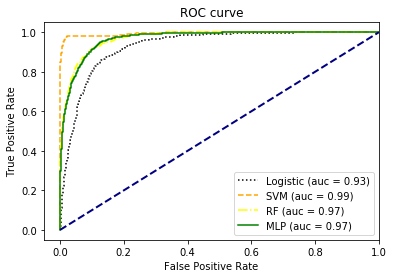

In [49]:
hybrid_model.roc_curve(clf, label, color, ls, hybrid_model.x_train, hybrid_model.y_train)

In [61]:
param_grid_h_rf = [
        {
            'n_estimators' : [1000],
            'criterion' : ['entropy'],
            'class_weight': [{0:1,1:4}, {0:1,1:3} ],
            'max_depth' : [6]
            
        }
       ]

param_grid_h_mlp = [
        {
            'activation' : ['relu'],
            'solver' : ['adam'],
            'hidden_layer_sizes': [
             (64,32,),(128,64,)#,(128,64,32,),(32,16,)
             ],
            'learning_rate' : ['constant','adaptive'],
            'learning_rate_init' : [0.001, 0.005],
            'random_state' : [1],
            'max_iter' : [10000]
        }
       ]

In [59]:
hybrid_model.meta_data()

In [62]:
hybrid_model.hybrid_model(param_grid_h_rf, param_grid_h_mlp, 3, 'f1_weighted')

hybrid RF training complete
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 3},
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.9819262252796855


/Library/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % sel

hybrid MLP training complete
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(64, 32), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
0.9794029400281504


In [65]:
clf_h = [hybrid_model.hybrid_rf, hybrid_model.hybrid_mlp]
label_h = ['hybrid_RF', 'hybrid_MLP']
color_h = [ 'orange', 'yellow']
ls_h = ['--', '-.']

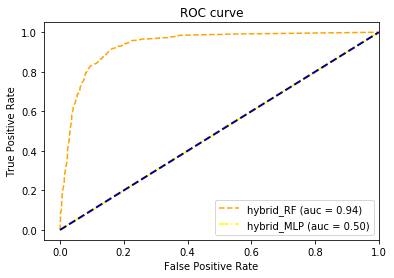

In [66]:
hybrid_model.roc_curve(clf_h, label_h, color_h, ls_h, hybrid_model.meta_test, hybrid_model.y_test)